In [1]:
import numpy as np
import copy
from qiskit import *
from qiskit.visualization import plot_histogram
from math import *
from qiskit.quantum_info import Pauli, state_fidelity, basis_state, process_fidelity
from qiskit.visualization import plot_bloch_vector
%matplotlib inline

In [2]:
def stater(qc):
    backend_sim = BasicAer.get_backend('statevector_simulator')
    result = execute(qc, backend_sim).result()
    state = result.get_statevector(qc)
    print(state)

original
[1.+0.j 0.+0.j]
insert h gate
[0.70710678+0.j 0.70710678+0.j]
insert rz gate
[0.70710678+0.j         0.61237244+0.35355339j]
insert ry gate
[0.0669873-0.25j 0.9330127+0.25j]


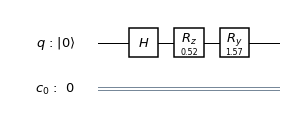

In [3]:
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'c')
qc = QuantumCircuit(q, c)
print("original")
stater(qc)
print("insert h gate")
qc.h(q)
stater(qc)
print("insert rz gate")
qc.rz(pi/6,q)
stater(qc)
print("insert ry gate")
qc.ry(pi/2,q)
stater(qc)
qc.draw(output='mpl')

In [4]:
meas = QuantumCircuit(q,c)
meas.measure(q, c)

# execute the quantum circuit 
backend = BasicAer.get_backend('qasm_simulator') # the device to run on
circ = qc+meas
result = execute(circ, backend, shots=10000).result()
counts  = result.get_counts(circ)
print(counts)

{'0': 681, '1': 9319}


In [5]:
# from https://quantumexperience.ng.bluemix.net/proxy/tutorial/full-user-guide/002-The_Weird_and_Wonderful_World_of_the_Qubit/005-The_Bloch_Sphere.html
meas_x = QuantumCircuit(q, c)
meas_x.h(q)
meas_x.measure(q, c)

meas_y = QuantumCircuit(q, c)
meas_y.s(q).inverse()
meas_y.h(q)
meas_y.measure(q, c)

meas_z = QuantumCircuit(q, c)
meas_z.measure(q, c)

bloch_vector = ['x', 'y', 'z']
exp_vector = range(0, 21)
circuits = []

for exp_index in exp_vector:
    middle = QuantumCircuit(q, c)
    phase = 2*np.pi*exp_index/(len(exp_vector)-1)
    middle.u1(phase, q)
    circuits.append(qc + middle + meas_x)
    circuits.append(qc + middle + meas_y)
    circuits.append(qc + middle + meas_z)
    
job = execute(circuits,
              backend = Aer.get_backend('qasm_simulator'),
              shots=1024)
result = job.result()

for exp_index in exp_vector:
    bloch = [0, 0, 0]
    for bloch_index in range(len(bloch_vector)):
        data = result.get_counts(circuits[3*exp_index+bloch_index])
        try:
            p0 = data['0']/1024.0
        except KeyError:
            p0 = 0
        try:
            p1 = data['1']/1024.0
        except KeyError:
            p1 = 0
        bloch[bloch_index] = p0-p1

[-0.04296875, -0.517578125, -0.833984375]


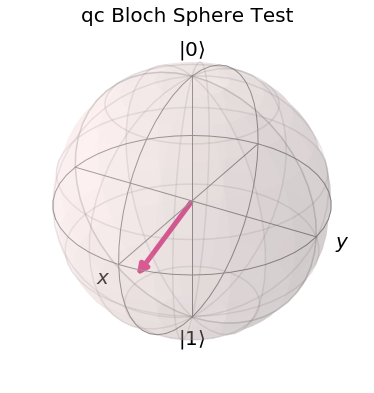

In [6]:
print(bloch)
plot_bloch_vector(bloch, title='qc Bloch Sphere Test')
#this graph is the result of the qc circuit of one qubit

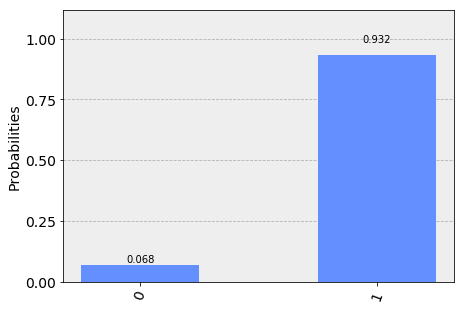

In [7]:
plot_histogram(counts)

In [8]:
a_counts=counts['0']/10000

In [9]:
alpha = np.arccos(a_counts)
print(alpha)

1.5026435797680187


In [10]:
def executer(q,c,qc):
    meas = QuantumCircuit(q,c)
    meas.measure(q, c)
    backend = BasicAer.get_backend('qasm_simulator') # the device to run on
    circ = qc+meas
    result = execute(circ, backend, shots=100000).result()
    counts  = result.get_counts(circ)
    if len(counts) == 1:
        if '0' in counts:
            return -1
        else:
            return 1
    else:
        if counts['0'] > 50000:
            return (-2 * ((counts['0']/100000) - 0.5))
        else:
            return (2 * ((counts['1']/100000) - 0.5))

In [11]:
def componentFinder(qc):
    # x component
    x_finder = copy.deepcopy(qc)
    x_finder.ry(pi/2,q)
    x_counts = executer(q, c, x_finder)
    one = x_counts
    print('x component =', one)
    # y component
    y_finder = copy.deepcopy(qc)
    y_finder.rx(pi/2,q)
    y_counts = executer(q, c, y_finder)
    two = y_counts
    print('y component =', two)
    # z component
    z_finder = copy.deepcopy(qc)
    z_finder.ry(pi, q)
    z_counts = executer(q, c, z_finder)
    three = z_counts
    print('z component =', z_counts)
    coordinate = [one, two, three]
    # print('returns coordinates of state vector (rcos(theta) of components)')
    print(coordinate)
    return coordinate

x component = -0.00015999999999993797
y component = -0.4961
z component = -0.8646799999999999
[-0.00015999999999993797, -0.4961, -0.8646799999999999]


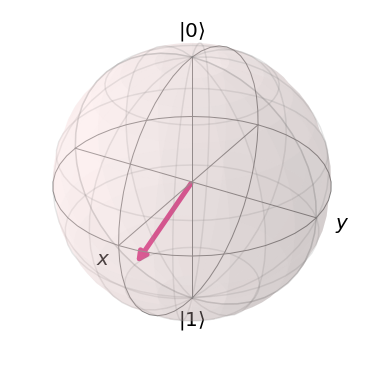

In [12]:
coordinate = componentFinder(qc)
plot_bloch_vector(coordinate)